In [138]:
import torch
import math
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



In [139]:
class Value:
    def __init__(self, data, _children = (), _op='', label=''):
        self.data = data
        self._backward =lambda: None
        self.grad = 0.0
        self._prev = set(_children)
        self._op =_op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 *out.grad
            other.grad += 1.0 *out.grad    
        out._backward  = _backward
        
        return out
        
    def __rmul__(self, other):
        return self * other
    
    
    
    def __mul__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward  = _backward
        return out
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) -1) / (math.exp(2*n) +1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1- t**2)  * out.grad
            
        out._backward  = _backward
        return out 
    
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data  *out.grad
        out._backward  = _backward
        return out
    
    
    def __truediv__(self, other):
        return self * other**-1        
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float instances for now"
        out = Value(self.data **other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data **(other -1)) * out.grad
        out._backward  = _backward
        return out
        
        
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        
        return self + (-other) 
    
    
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        build_topo(self)
        topo
        self.grad =  1.0
        for node in reversed(topo):
            node._backward()

        
    

In [140]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [141]:
import random
#neural net is just a specific class of a math experssion
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        print(list(zip(self.w, x))) #takes two iterators and creates an iterator that iterates over t
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b] # list + list gives you a list

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [142]:
            
x= [2.0, 3.0,  -1.0]
n = MLP(3, [4,4,1])
n(x)
        

[(Value(data=-0.8758056805884786), 2.0), (Value(data=-0.6614933923717892), 3.0), (Value(data=0.05470906644004625), -1.0)]
[(Value(data=-0.2516213495992816), 2.0), (Value(data=0.6026532725651668), 3.0), (Value(data=0.13628455726529976), -1.0)]
[(Value(data=-0.9013030484930913), 2.0), (Value(data=-0.10050734970661956), 3.0), (Value(data=-0.32155046817929644), -1.0)]
[(Value(data=-0.15305282484085825), 2.0), (Value(data=-0.9169142447308958), 3.0), (Value(data=0.3162610702398554), -1.0)]
[(Value(data=-0.9052942342264982), Value(data=-0.9988952535256104)), (Value(data=-0.03205148099644206), Value(data=0.9352475239074789)), (Value(data=-0.9524647371489041), Value(data=-0.7565323810813342)), (Value(data=0.43078218615456754), Value(data=-0.9989209111338014))]
[(Value(data=0.1618601670776949), Value(data=-0.9988952535256104)), (Value(data=-0.6153460547254377), Value(data=0.9352475239074789)), (Value(data=0.6623857719265311), Value(data=-0.7565323810813342)), (Value(data=-0.5679528769718196), Va

Value(data=-0.20346599854853953)

In [143]:
from graphviz import Digraph


def trace(root):
  # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
        # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
          # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

[(Value(data=-0.8758056805884786), 2.0), (Value(data=-0.6614933923717892), 3.0), (Value(data=0.05470906644004625), -1.0)]
[(Value(data=-0.2516213495992816), 2.0), (Value(data=0.6026532725651668), 3.0), (Value(data=0.13628455726529976), -1.0)]
[(Value(data=-0.9013030484930913), 2.0), (Value(data=-0.10050734970661956), 3.0), (Value(data=-0.32155046817929644), -1.0)]
[(Value(data=-0.15305282484085825), 2.0), (Value(data=-0.9169142447308958), 3.0), (Value(data=0.3162610702398554), -1.0)]
[(Value(data=-0.9052942342264982), Value(data=-0.9988952535256104)), (Value(data=-0.03205148099644206), Value(data=0.9352475239074789)), (Value(data=-0.9524647371489041), Value(data=-0.7565323810813342)), (Value(data=0.43078218615456754), Value(data=-0.9989209111338014))]
[(Value(data=0.1618601670776949), Value(data=-0.9988952535256104)), (Value(data=-0.6153460547254377), Value(data=0.9352475239074789)), (Value(data=0.6623857719265311), Value(data=-0.7565323810813342)), (Value(data=-0.5679528769718196), Va

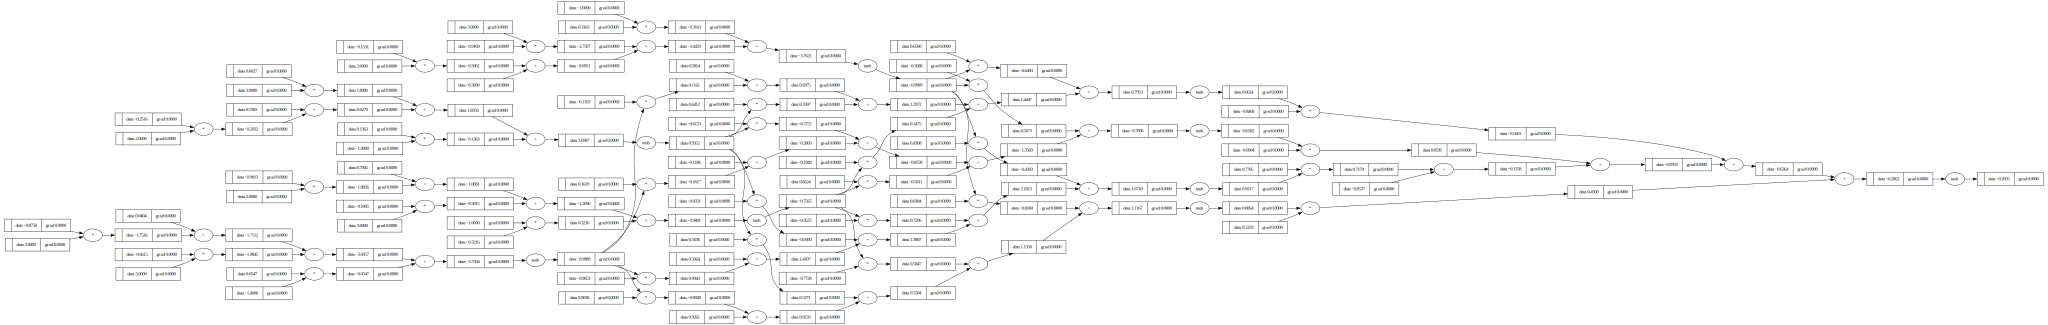

In [144]:
draw_dot(n(x))

In [133]:

# these are the inputs into the neural net
xs = [ 
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets to output
ypred = [n(x) for x in xs]
ypred

TypeError: 'Tensor' object is not callable

In [134]:
n.parameters()

AttributeError: 'Tensor' object has no attribute 'parameters'

In [167]:

loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred), Value(0))


SyntaxError: Generator expression must be parenthesized (3428410068.py, line 1)

In [168]:
loss.backward()
n.layers[0].neurons[0].w[0].grad


0.0

In [165]:
a = (1, 2, 3, 4, 5)
x = sum(a, Value(0))

x


Value(data=15)